In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [9]:
def  plot_confusion_matrixplot_con (cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [2]:
df = pd.read_pickle('data/interim/churn data.pickle')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn',axis=1), df.Churn, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [22]:
penalties = ['l1','l2']
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
results_auc = pd.DataFrame()

for s in solvers:
    if s in ['newton-cg', 'lbfgs', 'sag']:
        logmodel = LogisticRegression(penalty='l2', solver=s)
        logmodel.fit(X_train,y_train)
        predictions = logmodel.predict(X_val)
        print('Results using',s,'as solver and l2 as penalty')
        print(classification_report(y_val, predictions))
        results_auc = results_auc.append(pd.DataFrame(data={
            'Solver': s,
            'Penalty': 'l2',
            'AUC': roc_auc_score(predictions,y_val)
        },index=[0]))
    else:
        for p in penalties:
            logmodel = LogisticRegression(penalty=p, solver=s)
            logmodel.fit(X_train,y_train)
            predictions = logmodel.predict(X_val)
            print('Results using',s,'as solver and',p,'as penalty')
            print(classification_report(y_val, predictions))
            results_auc = results_auc.append(pd.DataFrame(data={
                'Solver': s,
                'Penalty': p,
                'AUC': roc_auc_score(predictions,y_val)
            },index=[0]))
results_auc.sort_values('AUC',ascending=False,inplace=True)
results_auc

Results using newton-cg as solver and l2 as penalty
             precision    recall  f1-score   support

          0       0.84      0.90      0.87       814
          1       0.68      0.55      0.61       313

avg / total       0.79      0.80      0.80      1127

Results using lbfgs as solver and l2 as penalty
             precision    recall  f1-score   support

          0       0.84      0.90      0.87       814
          1       0.68      0.56      0.61       313

avg / total       0.80      0.80      0.80      1127

Results using liblinear as solver and l1 as penalty
             precision    recall  f1-score   support

          0       0.84      0.90      0.87       814
          1       0.68      0.55      0.61       313

avg / total       0.79      0.80      0.80      1127

Results using liblinear as solver and l2 as penalty
             precision    recall  f1-score   support

          0       0.84      0.91      0.87       814
          1       0.70      0.53      0.60  

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Results using sag as solver and l2 as penalty
             precision    recall  f1-score   support

          0       0.81      0.87      0.84       814
          1       0.58      0.46      0.51       313

avg / total       0.74      0.76      0.75      1127

Results using saga as solver and l1 as penalty
             precision    recall  f1-score   support

          0       0.81      0.87      0.84       814
          1       0.58      0.46      0.51       313

avg / total       0.74      0.76      0.75      1127

Results using saga as solver and l2 as penalty
             precision    recall  f1-score   support

          0       0.81      0.86      0.83       814
          1       0.56      0.46      0.51       313

avg / total       0.74      0.75      0.74      1127



,Solver,Penalty,AUC
0,liblinear,l2,0.769203
0,lbfgs,l2,0.761475
0,newton-cg,l2,0.758940
0,liblinear,l1,0.758940
0,sag,l2,0.691698
0,saga,l1,0.691698
0,saga,l2,0.683029


In [21]:
logmodel = LogisticRegression(penalty=results_auc.Penalty.iloc[0], solver=results_auc.Solver.iloc[0])
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
print(classification_report(y_test, logmodel.predict(X_test)))

             precision    recall  f1-score   support

          0       0.84      0.86      0.85      1061
          1       0.54      0.50      0.52       348

avg / total       0.77      0.77      0.77      1409



In [24]:
roc_auc_score(logmodel.predict(X_test),y_test)

0.6894337212602895

Normalized confusion matrix
[[0.8404059  0.1595941 ]
 [0.46153846 0.53846154]]


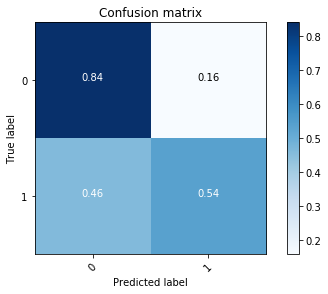

In [25]:
plot_confusion_matrixplot_con(cm=confusion_matrix(logmodel.predict(X_test),y_test),
                              classes=y_test.unique(), normalize=True)

In [26]:
joblib.dump(logmodel,'data/Models/Logistic regression.pkl')

['data/Models/Logistic regression.pkl']